In [1]:
import numpy as np
import imgaug as ia
import matplotlib.pyplot as plt
import imgaug as ia
from imgaug import augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
import matplotlib.patches as patches

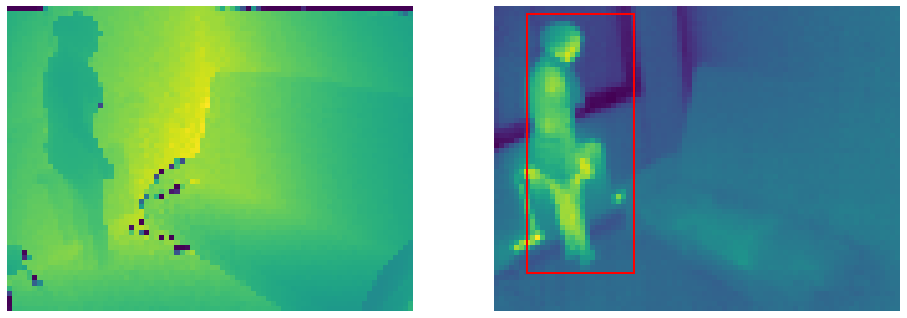

In [7]:
image = np.load('/home/mathurin/prudence/fusion/Serie27/Array/thermal_depth17.npy')
mean = np.mean(image, axis=(0,1))
std = np.std(image, axis=(0,1))

# Standardization
image = (image-mean)/std
image = image.astype('float32')
depth_image = image[:, :, 0]
thermal_image = image[:, :, 1]


bbox = (6,1,22,57)
w = bbox[2] - bbox[1]
h = bbox[3] - bbox[0]

bbs = BoundingBox(6,1,22,57)



image_stack = [depth_image, thermal_image]

# Create a Rectangle patch
rect = patches.Rectangle((bbox[0],bbox[1]), w, h, linewidth=2, edgecolor='r', facecolor='none')

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16,8))

ax1.axis('off')
ax1.imshow(depth_image)

ax2.axis('off')
ax2.imshow(thermal_image)
ax2.add_patch(rect)







In [70]:
augmenters = [
              iaa.Affine(rotate=(-25, 25)), # rotate image
              iaa.AdditiveGaussianNoise(scale=0.05*np.max(depth_image)),
              iaa.ElasticTransformation(alpha=(0, 20.0), sigma=(4.0, 6.0)),
              iaa.Dropout(p=(0.0, 0.1))
             ]
#seq = iaa.SomeOf((0, 2), augmenters, random_order=True)

seq = iaa.OneOf(augmenters)         
depth_aug, bbs_aug = seq(image=depth_image, bounding_boxes=bbs)
thermal_aug, _ = seq(image=image, bounding_boxes=bbs)
#thermal_aug, _ = seq(image=thermal_image, bounding_boxes=bbs)
bbs_aug_clipped = bbs_aug.clip_out_of_image(depth_aug)


rect = patches.Rectangle((bbs_aug_clipped.x1,bbs_aug_clipped.y1), bbs_aug_clipped.x2-bbs_aug_clipped.x1, bbs_aug_clipped.y2-bbs_aug_clipped.y1,linewidth=2,edgecolor='r',facecolor='none')

fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].axis('off')
ax[0].imshow(thermal_aug[:, :, 0], cmap='gray')
ax[0].add_patch(rect)
ax[1].axis('off')
ax[1].imshow(thermal_aug[:, :, 1], cmap='gray')



    

NameError: name 'depth_image' is not defined

## Crop and rotate

In [6]:
augmenters = [
              #iaa.Crop(percent=(0, 0.2)),
              iaa.Affine(rotate=(-45, 45))
             ]

for i in range(50):
    seq = iaa.Sequential(augmenters)
    print(seq)
    image_aug, bbs_aug = seq(image = depth_image, bounding_boxes=bbs)
    bbs_aug_clipped = bbs_aug.clip_out_of_image(image_aug)
    
    if bbs_aug_clipped.area/bbs_aug.area < 0.8:
        #Si on crop plus de 20% d'une bbox lors du clip_out_of_image(), on recommence.
        continue
           
    rect = patches.Rectangle((bbs_aug.x1,bbs_aug.y1), bbs_aug.x2-bbs_aug.x1, bbs_aug.y2-bbs_aug.y1,linewidth=10,edgecolor='r',facecolor='none')
    rect2 = patches.Rectangle((bbs_aug_clipped.x1,bbs_aug_clipped.y1), bbs_aug_clipped.x2-bbs_aug_clipped.x1, bbs_aug_clipped.y2-bbs_aug_clipped.y1,linewidth=2,edgecolor='b',facecolor='none')
    fig, ax = plt.subplots(figsize=(10, 7))
    ax.axis('off')
    plt.title('Augmentations for bounding boxes')
    ax.imshow(image_aug, cmap='gray')
    ax.add_patch(rect)
    ax.add_patch(rect2)
    

Sequential(name=UnnamedSequential, random_order=False, children=[Affine(name=UnnamedAffine, parameters=[Deterministic(float 1.00000000), Deterministic(int 0), Uniform(Deterministic(int -45), Deterministic(int 45)), Deterministic(float 0.00000000), Deterministic(int 1), Deterministic(int 0), Deterministic(constant), auto, False], deterministic=False)], deterministic=False)


NameError: name 'depth_image' is not defined

In [26]:
def data_augmentation(image, bbox):

    augmenters = [iaa.Crop(percent=(0, 0.2)),
                  iaa.Affine(rotate=(-20, 20)),
                  iaa.AdditiveGaussianNoise(scale=0.05 * np.max(image[0])),
                  iaa.ElasticTransformation(alpha=(0, 20.0), sigma=(4.0, 6.0)),
                  iaa.Dropout(p=(0.0, 0.1))]
    

    # 50 tries (in case the silhouette is to much outside the rotated image)
    for i in range(50):
        seq = iaa.SomeOf((0, 3), augmenters, random_order=True)
        image_aug, bbs_aug = seq(image=image, bounding_boxes=BoundingBox(*bbox))
        print(bbs_aug)
        bbs_clipped = bbs_aug.clip_out_of_image(image_aug)

        # Si on crop plus de 20% d'une bbox lors du clip_out_of_image(), on recommence.
        print(bbs_clipped.area / bbs_aug.area)
        if bbs_clipped.area / bbs_aug.area > 0.8:
            break

    return image_aug, (bbs_clipped.x1, bbs_clipped.y1, bbs_clipped.x2, bbs_clipped.y2)


def thermal_depth_image_preprocessing(image, bbox=None):
    '''
    Simple preprocessing for thermal images

    :param image: array image (h, w, c)
    :param bbox: box coordinates of the object in the image (TODO : allow mutliple boxes)
    :return: torch tensor of shape (2, w, h) and float32 type
    '''
    # Standardization
    mean = np.mean(image, axis=(0, 1))
    std = np.std(image, axis=(0, 1))
    image = (image - mean) / std
    image = image.astype('float32')

    image_aug, bbs_aug = data_augmentation(image, bbox)
    
    # Reshape to (2, 300, 300)
    new_img = skimage.transform.resize(image_aug, (300, 300))
    new_img = np.moveaxis(new_img, -1, 0)
    new_img = torch.FloatTensor(new_img)

    if bbox is not None:
        old_dims = [image.shape[1], image.shape[0], image.shape[1], image.shape[0]]
        bbs_aug = (np.array(list(bbs_aug)) / np.array(old_dims)).astype('float32')
        return new_img, bbs_aug
    return new_img

BoundingBox(x1=6.0000, y1=1.0000, x2=22.0000, y2=57.0000, label=None)
1.0


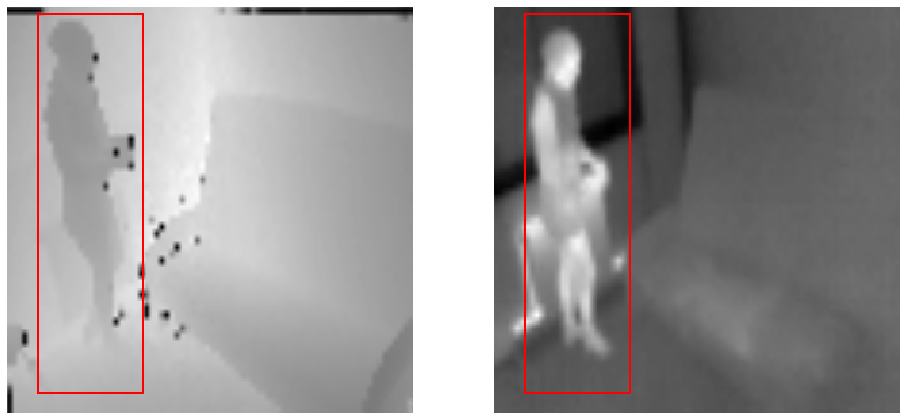

In [24]:
import skimage
import torch
image = np.load('/home/mathurin/prudence/fusion/Serie27/Array/thermal_depth18.npy')

bbox = [6,1,22,57]

aug = thermal_depth_image_preprocessing(image, bbox)
img_aug = aug[0]
bbs_aug = aug[1]

fig, ax = plt.subplots(1,2, figsize=(16,8))
ax[0].axis('off')
ax[0].imshow(img_aug[0, :, :], cmap='gray')

ax[1].axis('off')
ax[1].imshow(img_aug[1, :, :], cmap='gray')
rect = patches.Rectangle((bbs_aug[0]*300,bbs_aug[1]*300), bbs_aug[2]*300-bbs_aug[1]*300, bbs_aug[3]*300-bbs_aug[1]*300,linewidth=2,edgecolor='r',facecolor='none')
rect_2 = patches.Rectangle((bbs_aug[0]*300,bbs_aug[1]*300), bbs_aug[2]*300-bbs_aug[1]*300, bbs_aug[3]*300-bbs_aug[1]*300,linewidth=2,edgecolor='r',facecolor='none')
ax[0].add_patch(rect)
ax[1].add_patch(rect_2)

